<h1><center>FAIKR Project (State Collapse Network)</center></h1>
<center>The objective of this project is to apply Bayesian networks to the modelling of causes that lead to a state's collapse. The project aims to answer questions involving the conditional dependencies between the causes of a state's collapse.</center>
<br>

<h3><center>By: Gee Jun Hui Leonidas Yunani</center></h3>
<center>Email: leonidas.gee@studio.unibo.it</center>
<center>Academic Year: 2020 / 2021</center>

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
import networkx as nx

In [2]:
# Load and preview the dataset
data = pd.read_csv('dataset/QCA-Dataset complete 2014-11-04.csv', delimiter=';')
print('Number of rows and columns: {}'.format(data.shape))
data.head()

Number of rows and columns: (43, 31)


,case_ID,bur_obstr,factional,unoff_militia,informal,power_prop,milit,nic,personal_rule,polar,...,ex_threat,trade_open,aid,liberal,n_collapse,n_civ_war,sap,outcome,hybrid_regime,local_polity
0,Afghanistan 1973,0,0,0,1,2,0,0,1,0,...,1,1,1,0,0,1,0,0,0,0
1,Afghanistan 1979,1,0,1,2,2,1,0,2,0,...,0,1,0,0,0,1,0,1,0,0
2,Angola 1975,0,0,0,2,2,1,1,0,1,...,0,2,0,0,0,1,0,0,0,1
3,Angola 1992,1,0,0,1,1,1,0,0,0,...,2,2,1,1,0,0,0,1,1,1
4,Bosnia-Herzegovina 1992,0,1,0,0,2,1,1,0,1,...,0,2,0,1,0,1,0,1,0,0


The dataset that is selected has been composed by the University of Duisburg-Essen, Germany. The dataset can be downloaded from this [link](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LAUATA).

The dataset consists of 43 rows and 31 columns with each column (except for **case_ID** and **outcome**) representing a cause that can lead to a state’s collapse. The rows represent the countries at different points in time when they are stable (**outcome = 0**) and when they have collapsed (**outcome = 1**).

In [3]:
# Print all the columns of the dataset
print(data.columns.values)

['case_ID' 'bur_obstr' 'factional' 'unoff_militia' 'informal' 'power_prop'
 'milit' 'nic' 'personal_rule' 'polar' 'regime' 'sec_obstr' 'transition'
 'income' 'prim_comm_exp' 'gov_rev' 'pop_density' 'eth_min_rule' 'youth'
 'repression' 'polity' 'ex_threat' 'trade_open' 'aid' 'liberal'
 'n_collapse' 'n_civ_war' 'sap' 'outcome' 'hybrid_regime' 'local_polity']


For this project, only political factors are selected to build the Bayesian Network. This is in part to simplify the design and study of the network. As such, the following causes have been selected: **regime**, **eth_min_rule**, **personal_rule**, **repression**, **factional**, **milit**, **power_prop**.

In [4]:
# Select only relevant features from the dataset
df = data[['regime', 'eth_min_rule', 'personal_rule', 
           'repression', 'factional', 'milit', 
           'power_prop', 'outcome']]
df.index = data.case_ID.values
df.head()

,regime,eth_min_rule,personal_rule,repression,factional,milit,power_prop,outcome
Afghanistan 1973,2,0,1,0,0,0,2,0
Afghanistan 1979,2,0,2,1,0,1,2,1
Angola 1975,2,1,0,1,0,1,2,0
Angola 1992,1,1,0,1,0,1,1,1
Bosnia-Herzegovina 1992,0,0,0,0,1,1,2,1


## Description and Values of the Features

**Regime Type (REGIME)**

Regime type, classified as "Democracy", "Hybrid", or "Autocracy".

- 0 = democracy
- 1 = hybrid regime
- 2 = autocracy

**Ethnic Minority Rule (ETH_MIN_RULE)**

Political monopoly, or dominant political position in politics of an ethnic group which constitutes a numerical minority in the country.

- 0 = no ethnic minority rule 
- 1 = ethnic minority rule

**Personal Rule (PERSONAL_RULE)**

A type of state authority structure in which the ruler is an individual leader whose decision making power is institutionally unconstrained, who presides over a neopatrimonial public administration and who uses the patron client network as the principal institutional mechanism for wielding political power.

- 0 = no personalist regime 
- 1 = partially personalist regime
- 2 = personalist regime

**Repression (REPRESSION)**

Intensity of state repression against the population.

- 0 = no or low level of repression
- 1 = intermediate to high level of repression

**Factionalism (FACTIONAL)**

Political competition shaped by parochial or ethnic based political factions promoting particularist agendas.

- 0 = no factionalism 
- 1 = factionalism

**Militarised Opposition Groups (MILIT)**

Relevant oppositional actors are organised as armed groups.

- 0 = relevant opposition groups are unarmed 
- 1 = relevant opposition groups are armed

**Power Proportions (POWER PROP)**

Opposition's perception of the chance to take over government, based on actual power
relations to and attitude towards rulers.

- 0 = opposition does not see any chance for a regime change secession 
- 1 = opposition is doubtful of the chance for a regime change secession
- 2 = opposition is convinced of a good chance for a regime change secession

In [5]:
# Define the Bayesian Network
model = BayesianModel([('regime', 'repression'), 
                       ('eth_min_rule', 'repression'),
                       ('personal_rule', 'repression'),
                       ('repression', 'factional'),                       
                       ('milit', 'power_prop'),
                       ('factional', 'outcome'),                       
                       ('power_prop', 'outcome')])

The network is designed with the following logic:

1.	**Regime**, **Ethnic Minority Rule** and **Personal Rule** will determine if the Repression is applied by the government. The type of regime and the needs of its ruling class will determine if repression is required to stay in power.

2.	**Repression** will determine if **Factionalism** appears within the government. A government that represses its political class will have a lower factionalism as internal opposition is removed from positions of power, thus leading to less factionalism within the government.

3.	**Militarised Oppositional Groups** will determine the **Power Proportions** of external oppositional groups to the government. This is the belief of such groups of overthrowing the government by force.

4.	**Factionalism** and **Power Proportions** will determine the **Outcome** of a state. If the government is divided into many factions internally and if external opposition groups are confident in their force of arms, a state is more likely to collapse in such a scenario.

In [6]:
# Fit the data to the Bayesian Network to obtain the CPTs
model.cpds = []
model.fit(df)

# Print all the learned CPTs
for cpd in model.get_cpds():
    print('CPT of {}'.format(cpd.variable))
    print(cpd, '\n')

CPT of eth_min_rule
+-----------------+----------+
| eth_min_rule(0) | 0.697674 |
+-----------------+----------+
| eth_min_rule(1) | 0.302326 |
+-----------------+----------+ 

CPT of factional
+--------------+---------------+--------------------+
| repression   | repression(0) | repression(1)      |
+--------------+---------------+--------------------+
| factional(0) | 0.4           | 0.7142857142857143 |
+--------------+---------------+--------------------+
| factional(1) | 0.6           | 0.2857142857142857 |
+--------------+---------------+--------------------+ 

CPT of milit
+----------+---------+
| milit(0) | 0.55814 |
+----------+---------+
| milit(1) | 0.44186 |
+----------+---------+ 

CPT of outcome
+------------+---------------+---------------+---------------------+---------------+---------------+---------------+
| factional  | factional(0)  | factional(0)  | factional(0)        | factional(1)  | factional(1)  | factional(1)  |
+------------+---------------+---------------+-

In [7]:
# Rename the nodes for neater visualisation
G = nx.relabel_nodes(model, {'regime':'rgm', 'repression':'rpr', 'eth_min_rule':'emr', 
                             'personal_rule':'pr', 'factional':'fct', 'milit':'mlt', 
                             'power_prop':'pp', 'outcome':'out'})

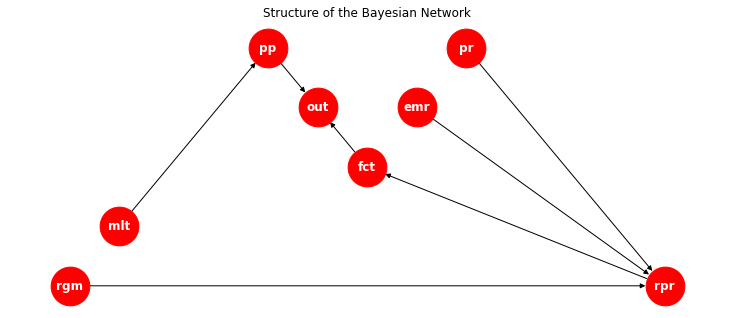

In [8]:
# Visualise the constructed Bayesian Network
plt.figure(figsize=(10, 4))
nx.draw_planar(G, node_color='r', node_size=1500, with_labels=True, 
               font_color='w', font_weight='bold')
plt.title('Structure of the Bayesian Network')
plt.show()

## Infering the Fitted Bayesian network

The Bayesian network can now be infered to answer questions regarding the  probability of certain causes of state collapse given some evidence. This is done using two alternative methods, namely the exact inference using variable elimination or approximate inference using likelihood weighted sampling.

In [9]:
# Define the inference function using variable elimination
def varElim(Q, evidence):
    infer = VariableElimination(model)
    
    string = ''
    lst = list(evidence.items())
    last = len(lst) - 1
    
    for i, pair in enumerate(lst):
        string += pair[0] + '=' + str(pair[1])
        if i != last:
            string += ', '
    
    prob = infer.query([Q], evidence=evidence, show_progress=False)
    val = prob.values
    
    print('Probability of {} given {}\n'.format(Q, string))
    print(prob)

In [10]:
# Define the inference function using likelihood weighted sampling
def sampLW(Q, evidence, sample_size):
    infer = BayesianModelSampling(model)
    
    samples = infer.likelihood_weighted_sample(evidence=evidence, size=sample_size, seed=0)
    
    unique = samples[Q].unique()
    unique.sort()
    
    string = ''
    last = len(evidence) - 1
    for i, pair in enumerate(evidence):
        string += pair[0] + '=' + str(pair[1])
        if i != last:
            string += ', '
    
    print('Probability of {} given {}\n'.format(Q, string))
    
    prob_lst = []
    for val in unique:
        rows = samples[samples[Q] == val]
        
        numerator = np.sum(rows['_weight'])
        denominator = np.sum(samples['_weight'])
        prob = round(numerator/denominator, 4)
        
        prob_lst.append(prob)
        
        print('{}({}) = {}'.format(Q, val, prob))

### What form of government will ethnic minority rule most likely take that does not lead to state collapse?

In countries such as South Africa during the Apartheid period, what form of government is necessary to prevent state collapse and is democracy possible for minority rule to be maintained?

In [11]:
# Inference using variable elimination
varElim('regime', {'eth_min_rule': 1, 'outcome': 0})

Probability of regime given eth_min_rule=1, outcome=0

+-----------+---------------+
| regime    |   phi(regime) |
+===========+===============+
| regime(0) |        0.1370 |
+-----------+---------------+
| regime(1) |        0.3294 |
+-----------+---------------+
| regime(2) |        0.5336 |
+-----------+---------------+


In [12]:
# Inference using likelihood weighted sampling
sampLW('regime', [State('eth_min_rule', 1)], 10000)

Probability of regime given eth_min_rule=1

regime(0) = 0.143
regime(1) = 0.3271
regime(2) = 0.5299


An ethnic minority government will most likely take the form of an autocracy to prevent state collapse. This is due to the need to control the ethnically different population of a much larger demographic. A democracy will probably lead to the ethnic minority rulers being swept away in an election.

### What is the probability that a democracy with personal rule will lead to repression?

During the Trump presidency, personal rule and loyalty defined the White House and the USA. In such a case, is it possible that a democracy with personal rule will lead to repression?

In [13]:
# Inference using variable elimination
varElim('repression', {'regime': 0, 'personal_rule': 1})

Probability of repression given regime=0, personal_rule=1

+---------------+-------------------+
| repression    |   phi(repression) |
+===============+===================+
| repression(0) |            0.8488 |
+---------------+-------------------+
| repression(1) |            0.1512 |
+---------------+-------------------+


In [14]:
# Inference using likelihood weighted sampling
sampLW('repression', [State('regime', 0), State('personal_rule', 1)], 10000)

Probability of repression given regime=0, personal_rule=1

repression(0) = 0.8502
repression(1) = 0.1498


The probability of repression by a democracy with personal rule is low. This is most likely due to the checks and balances that still exist within democracies to prevent such abuses of power.

### What is the probability that a united government and a militarised opposition will lead to state collapse?

When a government is united and not split by internal factions, is it able to overcome any attempt of state overthrow by an emboldened militarised opposition group?

In [15]:
# Inference using variable elimination
varElim('outcome', {'factional': 0, 'milit': 1})

Probability of outcome given factional=0, milit=1

+------------+----------------+
| outcome    |   phi(outcome) |
+============+================+
| outcome(0) |         0.6014 |
+------------+----------------+
| outcome(1) |         0.3986 |
+------------+----------------+


In [16]:
# Inference using likelihood weighted sampling
sampLW('outcome', [State('factional', 0), State('milit', 1)], 10000)

Probability of outcome given factional=0, milit=1

outcome(0) = 0.6031
outcome(1) = 0.3969


If the government is united without factionalism, the probability of a militarised opposition leading to a state collapse is relatively low. A united government will be able to coordinate military action against such groups more easily, thus reducing the probability of government overthrow.

## Conclusion

The project has demonstrated the design and usage of Bayesian networks in modelling a given dataset. In this case, the model was used to answer questions involving the causes of state collapse. Such a model can be further improved by having more representative data and also a better model design by a human expert.